# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from IPython.display import display

In [4]:
PATH = 'data/nyc-taxi/'

# Load training and test data

The entire dataset has about 55,423,857 rows

In [5]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column)
cols_train = ['fare_amount', 'pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime']

# No 'fare_amount'
cols_test = ['pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'pickup_datetime']

In [6]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. Or try 10 million
total_chunk = 55423857 // chunksize + 1

print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')

Chunk size: 10,000,000
Total chunks required: 6


In [7]:
%%time
i=0
for df_chunk in pd.read_csv(f'{PATH}train.csv', usecols=cols_train, dtype=types, chunksize=chunksize):
    
    i = i+1
    # Each chunk is a corresponding dataframe
    print(f'DataFrame Chunk {i}/{total_chunk}')
    
    # Slicing off unnecessary components of the datetime and specifying the date format
    # results in a MUCH more efficient conversion to a datetime object.
    # notice that the second components is truncated as we don't really need that portion for this prediction
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], format='%Y-%m-%d %H') 
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

DataFrame Chunk 1/6
DataFrame Chunk 2/6
DataFrame Chunk 3/6
DataFrame Chunk 4/6
DataFrame Chunk 5/6
DataFrame Chunk 6/6
Wall time: 2min


In [8]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

del df_list

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [10]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [11]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-raw')

Wall time: 6.17 s


In [8]:
%%time
train_df = pd.read_feather('tmp/taxi-train-raw')

CPU times: user 663 ms, sys: 2.83 s, total: 3.49 s
Wall time: 9.28 s


In [9]:
test_df = pd.read_csv(f'{PATH}test.csv', usecols=cols_test, dtype=types)
test_df['pickup_datetime'] = test_df['pickup_datetime'].str.slice(0, 16)
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'], format='%Y-%m-%d %H') 

In [14]:
test_df.to_feather('tmp/taxi-test-raw')

# Quick EDA

In [15]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:00,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:00,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:00,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:00,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:00,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:00,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [16]:
display(test_df.head())
display(test_df.tail())

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:00,-73.966049,40.789776,-73.988564,40.744427,1


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9909,2015-05-10 12:37:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:00,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:00,-73.988022,40.754070,-74.000282,40.759220,6


In [17]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.54239e+07,NaN,5.54239e+07,5.54239e+07,5.54235e+07,5.54235e+07,5.54239e+07
mean,11.345,NaN,-72.5097,39.9198,-72.5111,39.9207,1.68538
std,20.7108,NaN,12.8489,9.64235,12.7822,9.63335,1.32766
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208
counts,55423856,55423856,55423856,55423856,55423480,55423480,55423856
uniques,9405,3358837,98330,116546,114629,134778,15


In [18]:
DataFrameSummary(test_df).summary()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,NaN,9914,9914,9914,9914,9914
mean,NaN,-73.9747,40.751,-73.9737,40.7517,1.67127
std,NaN,0.042774,0.0335415,0.0390719,0.0354352,1.27875
min,NaN,-74.2522,40.5731,-74.2632,40.569,1
25%,NaN,-73.9925,40.7361,-73.9912,40.7353,1
50%,NaN,-73.9823,40.7531,-73.98,40.7541,1
75%,NaN,-73.968,40.7671,-73.9641,40.7688,2
max,NaN,-72.9865,41.7096,-72.991,41.6967,6
counts,9914,9914,9914,9914,9914,9914
uniques,1753,5894,7857,6174,8124,6


# Remove missing values

In [19]:
train_df.isnull().sum() 

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [20]:
test_df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [21]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df.dropna(how='any', axis='rows', inplace=True)

new_len = len(train_df)
print(f'New size: {old_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423856
New size: 55423856
376 rows removed


# Longitude, latitude and travel distance

## Bounding box for training data (absurd)

In [22]:
plongmin, plongmax = train_df.pickup_longitude.min(),train_df.pickup_longitude.max()
dlongmin, dlongmax = train_df.dropoff_longitude.min(),train_df.dropoff_longitude.max()
platmin, platmax = train_df.pickup_latitude.min(),train_df.pickup_latitude.max()
dlatmin, dlatmax = train_df.dropoff_latitude.min(),train_df.dropoff_latitude.max()

In [23]:
print("Bounding box for pickup")
print(f"({plongmin},{platmin},{plongmax},{platmax})")

Bounding box for pickup
(-3442.0595703125,-3492.263671875,3457.625732421875,3408.78955078125)


In [24]:
print(f"Bounding box for dropoff")
print(f"({dlongmin},{dlatmin},{dlongmax},{dlatmax})")

Bounding box for dropoff
(-3442.024658203125,-3547.88671875,3457.622314453125,3537.132568359375)


## Bounding box for test data

The latitude of New York City, NY, USA is **40.730610**, and the longitude is **-73.935242**.

In [25]:
plongmin, plongmax = test_df.pickup_longitude.min(),test_df.pickup_longitude.max()
dlongmin, dlongmax = test_df.dropoff_longitude.min(),test_df.dropoff_longitude.max()
platmin, platmax = test_df.pickup_latitude.min(),test_df.pickup_latitude.max()
dlatmin, dlatmax = test_df.dropoff_latitude.min(),test_df.dropoff_latitude.max()

In [26]:
print(f"pickup longitude min and max:\t {plongmin},  {plongmax}")
print(f"dropoff longitude min and max:\t {dlongmin},  {dlongmax}")
print()
print(f"pickup latitude min and max:\t  {platmin},  {platmax}")
print(f"dropoff longitude min and max:\t  {dlatmin},  {dlatmax}")

pickup longitude min and max:	 -74.25218963623047,  -72.98653411865234
dropoff longitude min and max:	 -74.26324462890625,  -72.990966796875

pickup latitude min and max:	  40.573143005371094,  41.709556579589844
dropoff longitude min and max:	  40.568973541259766,  41.69668197631836


In [27]:
print("Bounding box for pickup")
print(f"({plongmin},{platmin},{plongmax},{platmax})")

Bounding box for pickup
(-74.25218963623047,40.573143005371094,-72.98653411865234,41.709556579589844)


In [28]:
print(f"Bounding box for pickup")
print(f"({dlongmin},{dlatmin},{dlongmax},{dlatmax})")

Bounding box for pickup
(-74.26324462890625,40.568973541259766,-72.990966796875,41.69668197631836)


In [29]:
step = 0.3

longmin_limit = min(plongmin,dlongmin)-step
latmin_limit = min(platmin,dlatmin)-step 
latmax_limit = max(platmax,dlatmax)+step
longmax_limit = max(plongmax, dlongmax)+step

longmin_limit, latmin_limit, longmax_limit, latmax_limit

(-74.56324462890625, 40.26897354125977, -72.68653411865235, 42.00955657958984)

## Exclude training data for those outside bounding box

In [30]:
is_outside_plong = ~train_df.pickup_longitude.between(longmin_limit,longmax_limit)
is_outside_plat = ~train_df.pickup_latitude.between(latmin_limit,latmax_limit)

is_outside_dlong = ~train_df.dropoff_longitude.between(longmin_limit,longmax_limit)
is_outside_dlat = ~train_df.dropoff_latitude.between(latmin_limit,latmax_limit)

is_outside_plong.sum(), is_outside_plat.sum(), is_outside_dlong.sum(), is_outside_dlat.sum()

(1102761, 1096881, 1097710, 1095475)

In [31]:
is_outside_range = is_outside_plong | is_outside_plat | is_outside_dlong | is_outside_dlat
is_outside_range.sum()

1170362

## Comparisons of bounding boxes

Black box is bounding box with step 0.3, blue boxes are pickup and dropoff bounding box

1,170,362 outside range

http://bboxfinder.com/#40.268974,-74.563245,42.009557,-72.686534 



![bbox with 0.3 step limit](./img/bbox-0.3.jpg)

Black box is bounding box with step 0.02, blue boxes are pickup and dropoff bounding box

1,182,186 outside range

http://bboxfinder.com/#40.548974,-74.283245,41.729557,-72.966534

![bbox with 0.02 step limit](./img/bbox-0.02.jpg)

## Remove those outside range

In [32]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[~is_outside_range] # keep those NOT outside range

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 55423480
New size: 54253118
1,170,362 rows removed


## Checkpoint 1

In [33]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [34]:
%%time
train_df.to_feather('tmp/taxi-train-v6-chkpt1')

Wall time: 7.04 s


In [35]:
%%time
test_df.to_feather('tmp/taxi-test-v6-chkpt1')

Wall time: 8.98 ms


In [36]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v6-chkpt1')

Wall time: 1.13 s


In [37]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v6-chkpt1')

Wall time: 1.98 ms


## Add travel vector and simple distance

In [38]:
def add_travel_vector_features(df):
    df['longitude_distance'] = df.dropoff_longitude - df.pickup_longitude
    df['latitude_distance'] = df.dropoff_latitude - df.pickup_latitude

In [39]:
# manhattan distance more suitable than haversine distance (as the crow flies) or pythagorean distance
def add_simple_distance(df):
    df['simple_distance'] = np.abs(df.longitude_distance)  + np.abs(df.latitude_distance)

In [40]:
add_travel_vector_features(train_df)
add_travel_vector_features(test_df)

add_simple_distance(train_df)
add_simple_distance(test_df)

## Distance

In [41]:
test_df.simple_distance.min(), test_df.latitude_distance.abs().min(),  test_df.longitude_distance.abs().min()

(0.0, 0.0, 0.0)

In [42]:
# zero travel distance - cancellation? minimum payment such as booking fee?

(len(test_df[test_df.simple_distance == 0]), 
len(test_df[test_df.latitude_distance == 0]),
len(test_df[test_df.longitude_distance == 0]))

(85, 85, 87)

In [43]:
train_df.simple_distance.min(), train_df.latitude_distance.abs().min(), train_df.longitude_distance.abs().min()

(0.0, 0.0, 0.0)

In [44]:
(len(train_df[train_df.simple_distance == 0]), 
len(train_df[train_df.latitude_distance == 0]),
len(train_df[train_df.longitude_distance == 0]))

(584182, 600373, 614239)

In [45]:
# check fare_amount for zero travel distance from training data
train_df[train_df.simple_distance == 0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,longitude_distance,latitude_distance,simple_distance
count,584182.000000,584182.000000,584182.000000,584182.000000,584182.000000,584182.000000,584182.0,584182.0,584182.0
mean,11.293105,-73.943489,40.760910,-73.943489,40.760910,1.666486,0.0,0.0,0.0
std,16.132507,0.137193,0.100673,0.137193,0.100673,1.326600,0.0,0.0,0.0
min,-100.000000,-74.561195,40.273090,-74.561195,40.273090,0.000000,0.0,0.0,0.0
25%,4.900000,-73.990662,40.733696,-73.990662,40.733696,1.000000,0.0,0.0,0.0
50%,6.900000,-73.975677,40.752262,-73.975677,40.752262,1.000000,0.0,0.0,0.0
75%,10.500000,-73.948006,40.767849,-73.948006,40.767849,2.000000,0.0,0.0,0.0
max,3130.300049,-72.716026,41.916325,-72.716026,41.916325,208.000000,0.0,0.0,0.0


In [46]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,longitude_distance,latitude_distance,simple_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273,0.001066,0.000702,0.045481
std,0.042774,0.033541,0.039072,0.035435,1.278747,0.043501,0.033826,0.055975
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,-0.849174,-0.633213,0.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,-0.011496,-0.014214,0.017006
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,0.001682,0.000158,0.029110
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,0.014906,0.015326,0.052960
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,0.392708,0.237133,1.479969


In [47]:
test_df.simple_distance.max(), test_df.latitude_distance.abs().max(), test_df.longitude_distance.abs().max()

(1.479969, 0.63321304, 0.8491745)

In [48]:
train_df.simple_distance.max(), train_df.latitude_distance.abs().max(), train_df.longitude_distance.abs().max()

(2.3284569, 1.4536896, 1.4086685)

In [49]:
step = 0.1

is_outside_longitude_distance = train_df.longitude_distance>test_df.longitude_distance.max()+step*2
is_outside_latitude_distance = train_df.latitude_distance>test_df.latitude_distance.max()+step
is_outside_simple_distance = train_df.simple_distance>test_df.simple_distance.max()+step

is_outside_longitude_distance.sum(),is_outside_latitude_distance.sum(), is_outside_simple_distance.sum()

(2118, 3413, 126)

In [50]:
is_outside_extreme_range = is_outside_longitude_distance | is_outside_latitude_distance | is_outside_simple_distance
is_outside_extreme_range.sum()

3853

In [51]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[~is_outside_extreme_range]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54253118
New size: 54249265
3,853 rows removed


# Passenger Count

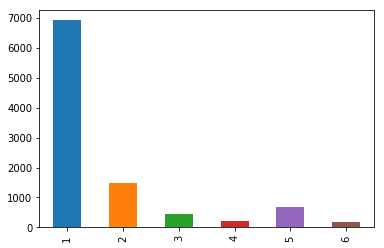

In [52]:
test_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [53]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

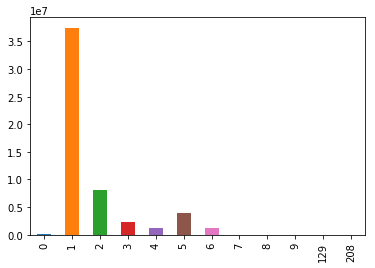

In [54]:
train_df.passenger_count.value_counts(sort=False).plot(kind='bar')

In [55]:
train_df.passenger_count.value_counts().sort_index()

0        190842
1      37515260
2       8012761
3       2382870
4       1155521
5       3841726
6       1150220
7            13
8             7
9            21
129           2
208          22
Name: passenger_count, dtype: int64

In [56]:
# number rows with passenger = 0 or more than 6
len(train_df[~(train_df.passenger_count.between(1,6))])

190907

In [57]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.passenger_count.between(1,6))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54249265
New size: 54058358
190,907 rows removed


## Checkpoint 2

In [58]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [59]:
%%time
train_df.to_feather('tmp/taxi-train-v6-chkpt2')

Wall time: 9.19 s


In [60]:
%%time
test_df.to_feather('tmp/taxi-test-v6-chkpt2')

Wall time: 15.3 ms


In [6]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v6-chkpt2')

CPU times: user 664 ms, sys: 3.24 s, total: 3.91 s
Wall time: 19 s


In [7]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v6-chkpt2')

CPU times: user 30 µs, sys: 4.05 ms, total: 4.08 ms
Wall time: 9.53 ms


# Fare Amount

In [63]:
train_df.fare_amount.median(), train_df.fare_amount.mean()

(8.5, 11.328848)

In [64]:
(train_df.fare_amount.quantile(0.99), train_df.fare_amount.quantile(0.999),
 train_df.fare_amount.quantile(0.9999),train_df.fare_amount.quantile(0.99999),
 train_df.fare_amount.quantile(0.999999))

(52.0, 78.1500015258789, 135.4416445388265, 228.0333151628214, 450.0)

In [65]:
(len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.999))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.9999))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99999))]),
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.999999))]))

(540039, 54058, 5406, 541, 53)

In [66]:
fare_max = 250
fare_min = 2.5

len(train_df[~(train_df.fare_amount.between(fare_min,fare_max))])

4393

In [67]:
old_len = len(train_df)
print(f'Old size: {old_len}')

train_df = train_df[(train_df.fare_amount.between(fare_min,fare_max))]

new_len = len(train_df)
print(f'New size: {new_len}')
print(f'{(old_len-new_len):,} rows removed')

Old size: 54058358
New size: 54053965
4,393 rows removed


## Zero distance fare

In [68]:
# check fare_amount for zero travel distance from training data
train_df[train_df.simple_distance == 0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,longitude_distance,latitude_distance,simple_distance
count,583150.000000,583150.000000,583150.000000,583150.000000,583150.000000,583150.00000,583150.0,583150.0,583150.0
mean,11.228794,-73.943542,40.760933,-73.943542,40.760933,1.66790,0.0,0.0,0.0
std,14.698286,0.137111,0.100661,0.137111,0.100661,1.29864,0.0,0.0,0.0
min,2.500000,-74.561195,40.273090,-74.561195,40.273090,1.00000,0.0,0.0,0.0
25%,4.900000,-73.990662,40.733696,-73.990662,40.733696,1.00000,0.0,0.0,0.0
50%,6.900000,-73.975685,40.752262,-73.975685,40.752262,1.00000,0.0,0.0,0.0
75%,10.500000,-73.948059,40.767853,-73.948059,40.767853,2.00000,0.0,0.0,0.0
max,250.000000,-72.716026,41.916325,-72.716026,41.916325,6.00000,0.0,0.0,0.0


In [69]:
test_df[test_df.simple_distance == 0].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,longitude_distance,latitude_distance,simple_distance
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.0,85.0,85.0
mean,-73.922089,40.781349,-73.922089,40.781349,1.741176,0.0,0.0,0.0
std,0.181695,0.134858,0.181695,0.134858,1.337668,0.0,0.0,0.0
min,-74.047394,40.622555,-74.047394,40.622555,1.000000,0.0,0.0,0.0
25%,-73.983925,40.742584,-73.983925,40.742584,1.000000,0.0,0.0,0.0
50%,-73.970085,40.754883,-73.970085,40.754883,1.000000,0.0,0.0,0.0
75%,-73.951820,40.772038,-73.951820,40.772038,2.000000,0.0,0.0,0.0
max,-73.137390,41.366138,-73.137390,41.366138,6.000000,0.0,0.0,0.0


- There are 85 cases  of zero travel distance in test set. 
- There are 580K cases of zero travel distance in training set.
- Zero distance can also mean travel and come back to the same spot. In any case it's ambiguous case
- To investigate further

## Checkpoint 3

In [70]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [71]:
%%time
train_df.to_feather('tmp/taxi-train-v6-chkpt3')

Wall time: 8.82 s


In [72]:
%%time
test_df.to_feather('tmp/taxi-test-v6-chkpt3')

Wall time: 16 ms


In [8]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v6-chkpt3')

CPU times: user 725 ms, sys: 3.89 s, total: 4.61 s
Wall time: 36.7 s


In [9]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v6-chkpt3')

CPU times: user 1.02 ms, sys: 2.35 ms, total: 3.37 ms
Wall time: 6.77 ms


# Date Time

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54053965 entries, 0 to 54053964
Data columns (total 10 columns):
fare_amount           float32
pickup_datetime       datetime64[ns]
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
longitude_distance    float32
latitude_distance     float32
simple_distance       float32
dtypes: datetime64[ns](1), float32(8), uint8(1)
memory usage: 2.1 GB


In [11]:
def split_datetime(df):
    # Extract date attributes and then drop the pickup_datetime column
    df['year'] = (df['pickup_datetime'].dt.year-2000).astype('uint8')  
    df['month'] = df['pickup_datetime'].dt.month.astype('uint8')  
    df['week'] = df['pickup_datetime'].dt.week.astype('uint8')  
    df['dayofweek'] = df['pickup_datetime'].dt.dayofweek.astype('uint8')  
    df['day'] = df['pickup_datetime'].dt.day.astype('uint8')  
    df['hour'] = df['pickup_datetime'].dt.hour.astype('uint8')  
    
    df.drop('pickup_datetime', axis=1, inplace=True)

In [12]:
%%time
split_datetime(train_df)

CPU times: user 20.6 s, sys: 4.58 s, total: 25.1 s
Wall time: 24.7 s


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54053965 entries, 0 to 54053964
Data columns (total 15 columns):
fare_amount           float32
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
longitude_distance    float32
latitude_distance     float32
simple_distance       float32
year                  uint8
month                 uint8
week                  uint8
dayofweek             uint8
day                   uint8
hour                  uint8
dtypes: float32(8), uint8(7)
memory usage: 2.0 GB


In [14]:
split_datetime(test_df)

## Checkpoint 4

In [15]:
%%time
train_df.to_feather('tmp/taxi-train-v6-chkpt4')

CPU times: user 2.09 s, sys: 2.25 s, total: 4.34 s
Wall time: 18.9 s


In [16]:
%%time
test_df.to_feather('tmp/taxi-test-v6-chkpt4')

CPU times: user 12.1 ms, sys: 6.53 ms, total: 18.6 ms
Wall time: 11.6 ms


In [20]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v6-chkpt4')

Wall time: 9.71 s


In [21]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v6-chkpt4')

Wall time: 34.7 ms


# Add distance to city and airports

In [22]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    return (np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)).astype('float32')  

In [23]:
def add_distance_to_city_airports(df):
    # Distances to nearby airports, and city center
    # By reporting distances to these points, the model can somewhat triangulate other locations of interest
    nyc = (40.712775,-74.005973) # New York City
    jfk = (40.641311,-73.778139) # John F. Kennedy International Airport
    ewr = (40.689531,-74.174462) # Newark Liberty International Airport
    lgr = (40.776927,-73.873966) # LaGuardia Airport
    
    df['pickup_distance_to_nyc'] = dist(nyc[0], nyc[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_nyc'] = dist(nyc[0], nyc[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_jfk'] = dist(jfk[0], jfk[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_jfk'] = dist(jfk[0], jfk[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_ewr'] = dist(ewr[0], ewr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_ewr'] = dist(ewr[0], ewr[1], df['dropoff_latitude'], df['dropoff_longitude'])
    df['pickup_distance_to_lgr'] = dist(lgr[0], lgr[1], df['pickup_latitude'], df['pickup_longitude'])
    df['dropoff_distance_to_lgr'] = dist(lgr[0], lgr[1], df['dropoff_latitude'], df['dropoff_longitude'])

In [24]:
add_distance_to_city_airports(train_df)

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54053965 entries, 0 to 54053964
Data columns (total 23 columns):
fare_amount                float32
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count            uint8
longitude_distance         float32
latitude_distance          float32
simple_distance            float32
year                       uint8
month                      uint8
week                       uint8
dayofweek                  uint8
day                        uint8
hour                       uint8
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
dtypes: float32(16), uint8(7)
memory usage: 3.6 GB


# Add boolean flag to show fare increased from September 2012

In [26]:
def add_fare_increased_flag(df):
    flag = (((df.year==(2012-2000)) & (df.month>=9)) | (df.year>(2012-2000)))
    df['fare_increased'] = flag

In [27]:
add_fare_increased_flag(train_df)

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54053965 entries, 0 to 54053964
Data columns (total 24 columns):
fare_amount                float32
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count            uint8
longitude_distance         float32
latitude_distance          float32
simple_distance            float32
year                       uint8
month                      uint8
week                       uint8
dayofweek                  uint8
day                        uint8
hour                       uint8
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
fare_increased             bool
dtypes: bool(1), float32(16), uint8(7)
memory usage: 3.6 GB


# Repeat all the feature engineering on test dataframe

In [29]:
add_distance_to_city_airports(test_df)
add_fare_increased_flag(test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 23 columns):
pickup_longitude           9914 non-null float32
pickup_latitude            9914 non-null float32
dropoff_longitude          9914 non-null float32
dropoff_latitude           9914 non-null float32
passenger_count            9914 non-null uint8
longitude_distance         9914 non-null float32
latitude_distance          9914 non-null float32
simple_distance            9914 non-null float32
year                       9914 non-null uint8
month                      9914 non-null uint8
week                       9914 non-null uint8
dayofweek                  9914 non-null uint8
day                        9914 non-null uint8
hour                       9914 non-null uint8
pickup_distance_to_nyc     9914 non-null float32
dropoff_distance_to_nyc    9914 non-null float32
pickup_distance_to_jfk     9914 non-null float32
dropoff_distance_to_jfk    9914 non-null float32
pickup_distance_to_ewr   

## Checkpoint 5

In [30]:
%%time
train_df.to_feather('tmp/taxi-train-v6-chkpt5')

Wall time: 17.1 s


In [31]:
%%time
test_df.to_feather('tmp/taxi-test-v6-chkpt5')

Wall time: 16.3 ms


# Load Clean

In [5]:
%%time
train_df = pd.read_feather('tmp/taxi-train-v6-chkpt5')

CPU times: user 1.62 s, sys: 6.48 s, total: 8.1 s
Wall time: 46.2 s


In [6]:
%%time
test_df = pd.read_feather('tmp/taxi-test-v6-chkpt5')

CPU times: user 601 µs, sys: 5.16 ms, total: 5.76 ms
Wall time: 10.8 ms


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54053965 entries, 0 to 54053964
Data columns (total 24 columns):
fare_amount                float32
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
passenger_count            uint8
longitude_distance         float32
latitude_distance          float32
simple_distance            float32
year                       uint8
month                      uint8
week                       uint8
dayofweek                  uint8
day                        uint8
hour                       uint8
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_ewr     float32
dropoff_distance_to_ewr    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
fare_increased             bool
dtypes: bool(1), float32(16), uint8(7)
memory usage: 3.6 GB


In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 23 columns):
pickup_longitude           9914 non-null float32
pickup_latitude            9914 non-null float32
dropoff_longitude          9914 non-null float32
dropoff_latitude           9914 non-null float32
passenger_count            9914 non-null uint8
longitude_distance         9914 non-null float32
latitude_distance          9914 non-null float32
simple_distance            9914 non-null float32
year                       9914 non-null uint8
month                      9914 non-null uint8
week                       9914 non-null uint8
dayofweek                  9914 non-null uint8
day                        9914 non-null uint8
hour                       9914 non-null uint8
pickup_distance_to_nyc     9914 non-null float32
dropoff_distance_to_nyc    9914 non-null float32
pickup_distance_to_jfk     9914 non-null float32
dropoff_distance_to_jfk    9914 non-null float32
pickup_distance_to_ewr   

# Drop fields

In [47]:
fields_drop = ['passenger_count', 'month', 'year', 'day', 'dayofweek', 
              'pickup_distance_to_ewr', 'dropoff_distance_to_ewr' ]

In [48]:
train_df.drop(fields_drop, axis=1, inplace=True)

In [49]:
test_df.drop(fields_drop, axis=1, inplace=True)

In [50]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54053965 entries, 0 to 54053964
Data columns (total 17 columns):
fare_amount                float32
pickup_longitude           float32
pickup_latitude            float32
dropoff_longitude          float32
dropoff_latitude           float32
longitude_distance         float32
latitude_distance          float32
simple_distance            float32
week                       uint8
hour                       uint8
pickup_distance_to_nyc     float32
dropoff_distance_to_nyc    float32
pickup_distance_to_jfk     float32
dropoff_distance_to_jfk    float32
pickup_distance_to_lgr     float32
dropoff_distance_to_lgr    float32
fare_increased             bool
dtypes: bool(1), float32(14), uint8(2)
memory usage: 3.0 GB


In [51]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 16 columns):
pickup_longitude           9914 non-null float32
pickup_latitude            9914 non-null float32
dropoff_longitude          9914 non-null float32
dropoff_latitude           9914 non-null float32
longitude_distance         9914 non-null float32
latitude_distance          9914 non-null float32
simple_distance            9914 non-null float32
week                       9914 non-null uint8
hour                       9914 non-null uint8
pickup_distance_to_nyc     9914 non-null float32
dropoff_distance_to_nyc    9914 non-null float32
pickup_distance_to_jfk     9914 non-null float32
dropoff_distance_to_jfk    9914 non-null float32
pickup_distance_to_lgr     9914 non-null float32
dropoff_distance_to_lgr    9914 non-null float32
fare_increased             9914 non-null bool
dtypes: bool(1), float32(13), uint8(2)
memory usage: 532.6 KB


In [7]:
%%time
train_df.to_feather('tmp/taxi-train-v6-chkpt6')

CPU times: user 4.5 s, sys: 4.14 s, total: 8.64 s
Wall time: 4.58 s


In [8]:
%%time
test_df.to_feather('tmp/taxi-test-v6-chkpt6')

CPU times: user 19.8 ms, sys: 17.5 ms, total: 37.3 ms
Wall time: 20.8 ms
